In [5]:
import pickle
import pandas as pd

In [6]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


In [7]:
from tqdm import tqdm 

In [8]:
class BasicModule(nn.Module):
    def __init__(self):
        super(BasicModule, self).__init__()
        self.model_name = str(type(self))

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def save(self, path):
        torch.save(self.state_dict(), path)

In [9]:
read_train = open("../dataset/train.pkl", "rb")
df_train = pickle.load(read_train)
read_train.close()

In [10]:
df_train.head(10)

,Datat set name,Trained model,Wide target sequence\n(Total 47 bps = 4 bp neighboring sequence + 20 bp protospacer + 3 bp NGG PAM+ 20 bp neighboring sequence),Guide sequence ((G/g)N19),3' extension sequence of pegRNA,PBS length,RT length,PBS-RT length,"Prime edited sequence\n(input for deep learning, A/C/G/T indicates 3' extension (RT template-PBS) binding region)",Tm1\n(PBS),...,GC contents_1\n(PBS),GC contents_2\n(RT),GC contents_3\n(PBS-RT),MFE_1\n(pegRNA),MFE_2\n(-spacer),MFE_3\n(RT-PBS-PolyT),MFE_4\n(spacer only),MFE_5\n(Spacer+Scaffold),DeepSpCas9 score,Measured PE efficiency
0,HT-Training,DeepPE,TTTGGTGGATTGCTTTAATAAAGATGGATCTGTCAGACCTTGGAGCT,GTGGATTGCTTTAATAAAGA,TTAATAAAGATCGATCT,-0.291202,-0.2117,-0.248228,XXXXXXXXXXXXXXTTAATAAAGATCGATCTXXXXXXXXXXXXXXXX,-0.711763,...,-0.523621,-0.164494,-0.327361,0.294536,0.200917,0.183727,0.147280,-0.041324,-0.240167,0.035112
1,HT-Training,DeepPE,TTTGGTGGATTGCTTTAATAAAGATGGATCTGTCAGACCTTGGAGCT,GTGGATTGCTTTAATAAAGA,CTTTAATAAAGATCGATCT,-0.173555,-0.2117,-0.194174,XXXXXXXXXXXXCTTTAATAAAGATCGATCTXXXXXXXXXXXXXXXX,-0.492677,...,-0.412510,-0.164494,-0.297949,0.241081,0.200917,0.183727,0.147280,-0.041324,-0.240167,0.041597
2,HT-Training,DeepPE,TTCCTCACAGAGTGTTAAAAGCTATGGAAGGAAAATGGATAACAGCT,GCACAGAGTGTTAAAAGCTA,TTAAAAGCTATCGAAGG,-0.291202,-0.2117,-0.248228,XXXXXXXXXXXXXXTTAAAAGCTATCGAAGGXXXXXXXXXXXXXXXX,-0.623772,...,-0.380764,-0.064494,-0.203178,0.215006,0.047583,0.183727,0.061073,0.017172,0.175016,0.000000
3,HT-Training,DeepPE,AGGTCTGAATCTCAAGTTGATAAGTGGAGATGTTCTGTACATCAGCT,GTGAATCTCAAGTTGATAAG,AGTTGATAAGTCGAGAT,-0.291202,-0.2117,-0.248228,XXXXXXXXXXXXXXAGTTGATAAGTCGAGATXXXXXXXXXXXXXXXX,-0.538029,...,-0.237907,-0.164494,-0.203178,0.239778,0.172028,0.183727,0.138659,-0.130461,-0.050857,0.571349
4,HT-Training,DeepPE,TTTGGTGGATTGCTTTAATAAAGATGGATCTGTCAGACCTTGGAGCT,GTGGATTGCTTTAATAAAGA,TTAATAAAGATCGATCTGT,-0.291202,-0.1117,-0.194174,XXXXXXXXXXXXXXTTAATAAAGATCGATCTGTXXXXXXXXXXXXXX,-0.711763,...,-0.523621,-0.147827,-0.297949,0.294536,0.187583,0.183727,0.147280,-0.041324,-0.240167,0.000000
5,HT-Training,DeepPE,CGAATGTTTGCCATGAGATCTTTCTGGAACTGTATATTCTGGAAGCT,GGTTTGCCATGAGATCTTTC,GAGATCTTTCTCGAACT,-0.291202,-0.2117,-0.248228,XXXXXXXXXXXXXXGAGATCTTTCTCGAACTXXXXXXXXXXXXXXXX,-0.596468,...,-0.095050,-0.164494,-0.141087,0.204576,0.120917,0.044713,-0.033755,0.070096,-0.415450,0.000000
6,HT-Training,DeepPE,GTAAGCAAAAGTAGCTGCTAATAAAGGTGATTTGCCACTTAAAAGCT,GCAAAAGTAGCTGCTAATAA,CTGCTAATAAACGTGAT,-0.291202,-0.2117,-0.248228,XXXXXXXXXXXXXXCTGCTAATAAACGTGATXXXXXXXXXXXXXXXX,-0.544252,...,-0.095050,-0.264494,-0.203178,0.215006,0.098694,0.183727,0.000728,0.019957,-0.237845,0.691117
7,HT-Training,DeepPE,TCACAGACAAGTTGAAGATGACCTTGGTAAGCACTCAAAATACAGCT,GGACAAGTTGAAGATGACCT,AAGATGACCTTCGTAAG,-0.291202,-0.2117,-0.248228,XXXXXXXXXXXXXXAAGATGACCTTCGTAAGXXXXXXXXXXXXXXXX,-0.545651,...,-0.237907,-0.064494,-0.141087,0.166766,0.109806,0.138884,0.147280,-0.138817,0.278731,6.761687
8,HT-Training,DeepPE,AAAAAAGGATACAGTTTCTGTAAGTGGATCCAAGTTACTGAAAAGCT,GAGGATACAGTTTCTGTAAG,TTTCTGTAAGTCGATCC,-0.291202,-0.2117,-0.248228,XXXXXXXXXXXXXXTTTCTGTAAGTCGATCCXXXXXXXXXXXXXXXX,-0.573228,...,-0.237907,-0.064494,-0.141087,0.213702,0.143139,0.183727,-0.076858,0.084024,-0.065900,2.226531
9,HT-Training,DeepPE,AGGATTACAATTCTTCTAATGCCTTGGTAAGTCTTTATTTACTAGCT,GTACAATTCTTCTAATGCCT,TCTAATGCCTTCGTAAG,-0.291202,-0.2117,-0.248228,XXXXXXXXXXXXXXTCTAATGCCTTCGTAAGXXXXXXXXXXXXXXXX,-0.597678,...,-0.237907,-0.064494,-0.141087,0.178500,0.072028,0.183727,0.147280,0.003244,-0.023462,0.000000


In [11]:
read_test = open("../dataset/test.pkl", "rb")
df_test = pickle.load(read_test)
read_test.close()

In [67]:
read_endo = open("../dataset/df_endo.pkl", "rb")
df_endo = pickle.load(read_endo)
read_endo.close()

In [68]:
import pickle as pk
preprocess_dict = pk.load(open("../dataset/preprocess_norm.pkl", "rb"))
preprocess_dict

{'PBS length': (11.950429029256695, 17),
 'RT length': (14.234001860849789, 20),
 'PBS-RT length': (26.184430890106484, 37),
 'Tm1\n(PBS)': (26.493439377648894, 71.1243),
 'Tm 2\n(target DNA region corresponding to RT template)': (39.5625099529616,
  70.7454),
 'Tm 3\n(reverse transcribed cDNA and PAM-opposite DNA strand)': (28.26598617026785,
  64.3746),
 'Tm 4\n(RT template region and reverse transcribed cDNA)': (38.74414902822284,
  73.5255),
 'deltaTm\n(Tm3-Tm2)': (-11.296523782693976, 22.6766),
 'GC count_1\n(PBS)': (6.256073606947172, 15),
 'GC count_2\n(RT)': (7.9944432957717355, 18),
 'GC count_3\n(PBS-RT)': (14.250516902718909, 29),
 'GC contents_1\n(PBS)': (52.36212962662048, 100.0),
 'GC contents_2\n(RT)': (56.44935214859218, 100.0),
 'GC contents_3\n(PBS-RT)': (54.542563148423135, 94.7368421052632),
 'MFE_1\n(pegRNA)': (-47.89094903339193, 76.7),
 'MFE_2\n(-spacer)': (-26.441251421482363, 45.0),
 'MFE_3\n(RT-PBS-PolyT)': (-4.097110513801249, 22.3),
 'MFE_4\n(spacer only)': 

In [70]:
df_train.head(2)

,Datat set name,Trained model,Wide target sequence\n(Total 47 bps = 4 bp neighboring sequence + 20 bp protospacer + 3 bp NGG PAM+ 20 bp neighboring sequence),Guide sequence ((G/g)N19),3' extension sequence of pegRNA,PBS length,RT length,PBS-RT length,"Prime edited sequence\n(input for deep learning, A/C/G/T indicates 3' extension (RT template-PBS) binding region)",Tm1\n(PBS),...,GC contents_1\n(PBS),GC contents_2\n(RT),GC contents_3\n(PBS-RT),MFE_1\n(pegRNA),MFE_2\n(-spacer),MFE_3\n(RT-PBS-PolyT),MFE_4\n(spacer only),MFE_5\n(Spacer+Scaffold),DeepSpCas9 score,Measured PE efficiency
0,HT-Training,DeepPE,TTTGGTGGATTGCTTTAATAAAGATGGATCTGTCAGACCTTGGAGCT,GTGGATTGCTTTAATAAAGA,TTAATAAAGATCGATCT,-0.291202,-0.2117,-0.248228,XXXXXXXXXXXXXXTTAATAAAGATCGATCTXXXXXXXXXXXXXXXX,-0.711763,...,-0.523621,-0.164494,-0.327361,0.294536,0.200917,0.183727,0.14728,-0.041324,-0.240167,0.035112
1,HT-Training,DeepPE,TTTGGTGGATTGCTTTAATAAAGATGGATCTGTCAGACCTTGGAGCT,GTGGATTGCTTTAATAAAGA,CTTTAATAAAGATCGATCT,-0.173555,-0.2117,-0.194174,XXXXXXXXXXXXCTTTAATAAAGATCGATCTXXXXXXXXXXXXXXXX,-0.492677,...,-0.412510,-0.164494,-0.297949,0.241081,0.200917,0.183727,0.14728,-0.041324,-0.240167,0.041597


In [78]:
train_set.y.max()

tensor(60.3784)

In [69]:
df_endo = df_endo[df_endo[df_endo.columns[5]] != 'not deteceted']
df_endo[df_endo.columns[3]] = (df_endo[df_endo.columns[3]] - preprocess_dict['PBS length'][0]) / preprocess_dict['PBS length'][1]
df_endo[df_endo.columns[4]] = (df_endo[df_endo.columns[4]] - preprocess_dict['RT length'][0]) / preprocess_dict['RT length'][1]
# df_endo = df_endo[df_endo[df_endo.columns[5]] > 0]
df_endo

,Wide target sequence\n(Total 47 bps = 4 bp neighboring sequence + 20 bp protospacer + 3 bp NGG PAM+ 20 bp neighboring sequence),Guide sequence ((G/g)N19),3' extension sequence of pegRNA,PBS length (nt),RT template length (nt),Endo-BR1-TR1\nMeasured prime edting efficiency in HEK293T cells (%),Endo-BR1-TR2\nMeasured prime edting efficiency in HEK293T cells (%),Endo-BR2-TR1\nMeasured prime edting efficiency in HEK293T cells (%),Endo-BR2-TR2\nMeasured prime edting efficiency in HEK293T cells (%),Endo-BR2-TR3\nMeasured prime edting efficiency in HEK293T cells (%),Endo-BR3\nMeasured prime edting efficiency in HEK293T cells (%)
1,TGGGTCCGCTGGTGCACTACGAGCTGGGAGCGCTGGCTGAAGCAGCT,GCCGCTGGTGCACTACGAGC,XXXXXXXXCTGGTGCACTACGAGCTCGGAGCXXXXXXXXXXXXXXXX,0.061739,-0.2117,1.23685,1.204416,0.764088,0.50204,0.527295,0.5285
2,CCCAAAGCGCATCCAGCACCGACATGGTGAACAAGGCCCGTGGCAGG,GAGCGCATCCAGCACCGACA,XXXXXXXXGCATCCAGCACCGCAAGGCCCGTGGCAXXXXXXXXXXXX,0.061739,-0.0117,1.969306,1.97615,0.897066,0.888395,1.370432,2.13513
3,AGTTCTACGTGAACAGCACACTTAAGGAACTGAGGAGGCTCTTAGCT,GTACGTGAACAGCACACTTA,XXXXXXXXXXGAACAGCACACTTAACGAACTGAGGAXXXXXXXXXXX,-0.055908,0.0383,5.130204,4.632768,2.013889,2.565344,2.610966,3.536802
4,TGCTCAATTCTGAAGTCACTTTTTTGGTTGTAGAAATGACTGTAGCT,GAATTCTGAAGTCACTTTTT,XXXXXXATTCTGAAGTCACTTTTTTCGTTGTAGAAAXXXXXXXXXXX,0.179387,0.0383,0,not deteceted,not deteceted,not deteceted,not deteceted,0.009676
5,GTAAATACCTGAAAATGCTTAAAGAGGAAAAGAGGGAAGAAGAAGCT,GTACCTGAAAATGCTTAAAG,XXXXXXACCTGAAAATGCTTAAAGACGAAAAGAGGGAAGAAXXXXXX,0.179387,0.2883,0.275,0.324281,0,0.141643,0,0.101477
6,CTGCCATCTTCATTTTTGAACTTTTGGGTTCAAACTCAGAAGGAGCT,GATCTTCATTTTTGAACTTT,XXXXXXXXXXXXXXTTTGAACTTTTCGGTTCAAACTCAGAAXXXXXX,-0.291202,0.2883,0,0,0.028153,0,0,0.008921
7,CAGGGGTGGCTCACCTCTAGGTACCGGCTTTCCCCTCTTAGAGAGCT,GGTGGCTCACCTCTAGGTAC,XXXXXXXXXXXXXXCTCTAGGTACCCGCTTTCCXXXXXXXXXXXXXX,-0.291202,-0.1117,12.868687,12.365416,11.029412,11.499923,12.385321,13.01098
8,GAGTGCACTGTCACGGGTTTTCTGCGGGACAAGCTGCAGTACAAGCT,GCACTGTCACGGGTTTTCTG,XXXXXXXXXXTCACGGGTTTTCTGCCGGACAAGCTGCAGTAXXXXXX,-0.055908,0.2883,1.207668,1.007839,0.769958,0.945236,0.920658,1.080477
10,CCTCAACATCTATAAAGACCGTCCTGGCAGATACATCTGGATCAGCT,GACATCTATAAAGACCGTCC,XXXXAACATCTATAAAGACCGTCCTCGCAGATACATCTGGAXXXXXX,0.297034,0.2883,0,0,0.107759,0,0,6.333527
11,TCACATTGTTGTTCACCTCCTCGATGGCATTCACCCTCTTCGAAGCT,GTTGTTGTTCACCTCCTCGA,XXXXXXXXTTGTTCACCTCCTCCTTGGCATTCACCCTXXXXXXXXXX,0.061739,0.0883,22.876484,20.887209,11.805781,13.174346,13.950762,22.09389


In [12]:
def encode_dna_seq(seq):
    encoding = np.zeros((len(seq), 4))
    # encode dna seq
    for i in range(len(seq)):
        # one hot encoding
        pos = "acgt".find(seq[i].lower())
        if pos >= 0:
            encoding[i][pos] += 1
    return encoding

def encode_dna_data(data):
    data_len = len(data)
    seq_len = len(data[0])
    data_encoding = None
    # one hot encoding
    embed = torch.nn.Embedding.from_pretrained(torch.FloatTensor([[0,0,0,0],
                                                                 [1,0,0,0],
                                                                 [0,1,0,0],
                                                                 [0,0,1,0],
                                                                 [0,0,0,1]    
                                                                 ]))
    baseToIndex ={
        "n":0,
        "x":0,
        "a":1,
        "c":2,
        "g":3,
        "t":4
    }
    
    
    return embed(torch.IntTensor([[baseToIndex[b.lower()] for b in data[I]] for I in range(data_len)]))

In [13]:
embed = torch.nn.Embedding.from_pretrained(torch.FloatTensor([[0,0,0,0],
                                                             [1,0,0,0],
                                                             [0,1,0,0],
                                                             [0,0,1,0],
                                                             [0,0,0,1]    
                                                             ]))
embed(torch.LongTensor([[0,2,1], [3,2,1]]))

tensor([[[0., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.]]])

In [14]:
# list(df_train[df_train.columns[8]])

In [79]:
class PEDataset(Dataset):
     
    def __init__(self, dataframe, target_col, pegrna_col, feat_cols, y_col):
        super(PEDataset, self).__init__()
        # target_col = 2
        # pegrna_col = 8
        # feat_cols = [5, 6]#[5,6,7] + list(range(9,26))
        # y_col = 26
        
        self.target_seq = encode_dna_data(dataframe[dataframe.columns[target_col]].values)
        self.pegrna_seq = encode_dna_data(dataframe[dataframe.columns[pegrna_col]].values)
        self.y = torch.FloatTensor(dataframe[dataframe.columns[y_col]].values.astype(float)) / 100
        self.feat_list = torch.FloatTensor(dataframe[dataframe.columns[feat_cols]].values.astype(float))
            
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return (self.target_seq[index], self.pegrna_seq[index], self.feat_list[index], self.y[index])
        
    # return a subset of dataset of given range
#     def get_subset(self, start, end):
        
#         return DNADataset([(self.x[i],self.y[i]) for i in range(start, end)], self.size)

In [80]:
train_set = PEDataset(df_train,   
        target_col = 2, 
        pegrna_col = 8,
        feat_cols = [5, 6],
        y_col = 26)

In [81]:
test_set = PEDataset(df_test,   
        target_col = 2,
        pegrna_col = 8,
        feat_cols = [5, 6],
        y_col = 26)

In [82]:
endo_set = PEDataset(df_endo,  
 target_col=0, 
 pegrna_col=2, 
 feat_cols=[3,4], 
 y_col=5)

In [103]:
class SimpleLSTM(BasicModule):
    def __init__(self,args):
        super(SimpleLSTM, self).__init__()
        self.dropout = nn.Dropout(args['dropout'])
        self.params = args
        self.model_type = "LSTM"
        self.lstm_target = nn.LSTM(input_size=args['num_features'],
                                   hidden_size=args['hidden_size'], 
                                   num_layers=args['num_layers'],
                                   batch_first=True,
                                   dropout=args['dropout'], 
                                   bidirectional=args['bidirectional'])
        
        self.lstm_pegrna = nn.LSTM(input_size=args['num_features'], 
                                   hidden_size=args['hidden_size'], 
                                   num_layers=args['num_layers'],
                                   batch_first=True, 
                                   dropout=args['dropout'],
                                   bidirectional=args['bidirectional'])
        
        N = 2 if self.params['bidirectional'] else 1
        # self.fc1 = nn.Linear(args['hidden_size'] * (args['seq_length']) * 2 * N + args['num_extra_feat'], args['out1'], bias=True)
        self.fc1 = nn.Linear(args['hidden_size'] * (args['seq_length'] //2) * 2 * N + args['num_extra_feat'], args['out1'], bias=True)
        self.fc2 = nn.Linear(args['out1'], args['out2'], bias=True)
        self.bn = nn.BatchNorm1d(args['out1'])
        self.relu = nn.ReLU(inplace=True)
        
    
    def forward(self, target, pegrna, feat):
        batch_size = target.size(0)
        lstm_target_out = self.lstm_target(target)[0]
        lstm_pegrna_out = self.lstm_pegrna(pegrna)[0]
        # print(lstm_target_out.shape, lstm_pegrna_out.shape)
        out_target = F.max_pool2d(lstm_target_out, (2,1), stride=(2,1))
        out_pegrna = F.max_pool2d(lstm_pegrna_out, (2,1), stride=(2,1))
        # print(out_target.shape, out_pegrna.shape)
        out_target = out_target.view(batch_size, -1)
        out_pegrna = out_pegrna.view(batch_size, -1)
        x = torch.cat((out_target, out_pegrna, feat), 1) 
#         print(x.shape)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        
        return x
    
    def setDropout(self, dropout):
        self.dropout.p = dropout
        self.lstm_pegrna.dropout = dropout
        self.lstm_target.dropout = dropout

In [104]:
# train_set.feat_list[:30]

In [105]:
lstm_args = {
    'seq_length': 47,
    'bidirectional': True,
    'num_features': 4,
    'num_layers': 2,
    'hidden_size': 25,
    'dropout': 0.5,
    'out1': 90,
    'out2': 1,
    'num_extra_feat': 2
}
lstm_model = SimpleLSTM(lstm_args).cuda()


In [106]:
train(lstm_model, train_set, 15 , 64, val_set=test_set, cv=0.0, learning_rate=0.0008)

605it [00:13, 44.61it/s]
0it [00:00, ?it/s]

0
0.539656067914596


605it [00:13, 45.00it/s]


1


3it [00:00, 27.29it/s]

0.6059287377733912


605it [00:13, 45.56it/s]
0it [00:00, ?it/s]

2
0.6695330486254463


605it [00:13, 46.52it/s]
0it [00:00, ?it/s]

3
0.7072211441000944


605it [00:13, 46.38it/s]
0it [00:00, ?it/s]

4
0.7343802661542603


605it [00:13, 46.00it/s]
0it [00:00, ?it/s]

5
0.7342275232744204


605it [00:13, 45.10it/s]
0it [00:00, ?it/s]

6
0.7610329293664269


605it [00:13, 45.63it/s]
0it [00:00, ?it/s]

7
0.7660677600978143


605it [00:13, 45.80it/s]
0it [00:00, ?it/s]

8
0.7760772891306059


605it [00:13, 46.20it/s]


9


4it [00:00, 35.02it/s]

0.7784684127431722


605it [00:13, 46.13it/s]
0it [00:00, ?it/s]

10
0.7892293257327038


605it [00:13, 45.68it/s]
0it [00:00, ?it/s]

11
0.7879609710608799


605it [00:13, 45.15it/s]


12


3it [00:00, 27.50it/s]

0.7773576125860859


605it [00:13, 44.78it/s]
0it [00:00, ?it/s]

13
0.7899577046527161


605it [00:13, 46.09it/s]


14
0.7866826401820145


In [123]:
lstm_model.save("../model/bilstm_hidden25_layer2_drpout5_fc90_79.cmodel")

<AxesSubplot:xlabel='True', ylabel='Predicted'>

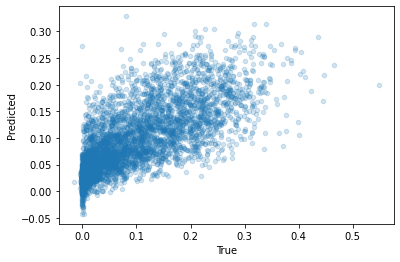

In [121]:
pd.DataFrame(np.array([test_scores(lstm_model, test_set, 500), test_set.y.detach().numpy()]).T, columns=['Predicted', "True"]).plot.scatter(x='True', y="Predicted", alpha=0.2)

<AxesSubplot:xlabel='True', ylabel='Predicted'>

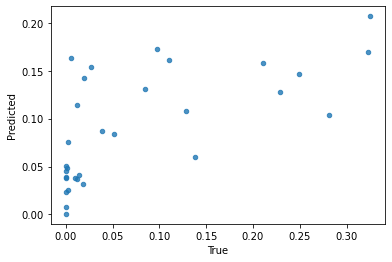

In [119]:
pd.DataFrame(np.array([test_scores(lstm_model, endo_set, 500), endo_set.y.detach().numpy()]).T, columns=['Predicted', "True"]).plot.scatter(x='True', y="Predicted", alpha=0.8)

In [25]:
def test_scores(model, test_set, batch_size):
    tscores = []
    for t, p, f, scores in DataLoader(test_set, batch_size=batch_size):
        model.zero_grad()
        target_seq = Variable(t.cuda())
        pegrna_seq = Variable(p.cuda())
        feats = Variable(f.cuda())
        scores = Variable(scores).cuda()
        out = model(target_seq, pegrna_seq, feats).squeeze()
        for v in out.cpu().detach().numpy():
            tscores.append(v)
    return tscores

def check_corr(model, test_set):
    model.setDropout(0.0)
    tscores = test_scores(model, test_set, 400)
    corr = pd.DataFrame([[float(test_set[i][-1]), tscores[i]] for i in range(len(tscores))], columns=['endogenous', 'integrated']).corr(method='spearman')['endogenous']['integrated']
    return corr

In [26]:
def train(model, train_dataset, epochs, batch_size, val_set, cv=0.1, learning_rate=0.001, start = 0, end = 0):
    subset = train_dataset
    n_training_samples = len(subset) * (1-cv)
    n_val_samples = len(subset) * cv
    train_loader =torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                              sampler=SubsetRandomSampler(
                                                  np.arange(n_training_samples, dtype=np.int64)
                                              ),
                                              num_workers=0)
    val_loader =torch.utils.data.DataLoader(subset, batch_size=100,
                                              sampler=SubsetRandomSampler(
                                                  np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64)
                                              ), num_workers=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    
    for e in range(epochs):
        # train loss
        epoch_train_loss = 0.0
        model.setDropout(model.params['dropout'])
        for (ii, (t, p, f, scores)) in tqdm(enumerate(train_loader)):
            # inp = inp.unsqueeze(1)
            target_seq = Variable(t.cuda())
            pegrna_seq = Variable(p.cuda())
            feats = Variable(f.cuda())
            scores = Variable(scores).cuda()
            optimizer.zero_grad()
            out = model(target_seq, pegrna_seq, feats).squeeze()
            loss = criterion(out, scores)
            epoch_train_loss += float(loss)
            loss.backward()
            optimizer.step()
                
        # validation loss
#         epoch_val_loss = 0.0
#         for inp, labels in val_loader:
#             inp = inp.unsqueeze(1)
#             out = model(inp)        
#             loss = criterion(out, labels)
#             epoch_val_loss += loss


#         print(str(epoch_train_loss) + ' ')
#         print(str(epoch_val_loss.tolist()) + '\n')
        model.setDropout(0.0)
        print(e)
    #     tscores = test_scores(model, val_set, 400)
    #     corr = pd.DataFrame([[val_set[i][0], float(val_set[i][1]), tscores[i]] for i in range(len(tscores))], columns=['seq', 'endogenous', 'integrated'])\
    # [['endogenous', 'integrated']].corr(method='spearman')['endogenous']['integrated']
    #     print(corr)
        # endo_score, test_score = (check_corr(model, val_set), check_corr(model, test_set))
        print(check_corr(model, val_set))
        # if endo_score >= 0.68 and test_score>=0.77:
        #     print("Saving.")
        #     model.save("%s_%s.model"%(model.params_to_str(), int(round(endo_score, 3)*100)))
        #     break

In [37]:
train(lstm_model, train_set, 15 , 64, val_set=test_set, cv=0.0, learning_rate=0.0008)

605it [00:07, 76.77it/s]
0it [00:00, ?it/s]

0
0.6704325549432076


605it [00:07, 77.79it/s]
0it [00:00, ?it/s]

1
0.7154716073812585


605it [00:07, 81.65it/s]
0it [00:00, ?it/s]

2
0.7265591334891969


605it [00:07, 80.50it/s]
0it [00:00, ?it/s]

3
0.7149483098605394


605it [00:07, 81.88it/s]
0it [00:00, ?it/s]

4
0.7468192145429945


605it [00:07, 83.98it/s]
0it [00:00, ?it/s]

5
0.7738228148367355


605it [00:07, 78.75it/s]
0it [00:00, ?it/s]

6
0.7699401024342021


605it [00:07, 76.77it/s]
0it [00:00, ?it/s]

7
0.7680668940953363


605it [00:07, 77.04it/s]
0it [00:00, ?it/s]

8
0.7723881913601066


605it [00:07, 77.86it/s]
0it [00:00, ?it/s]

9
0.7670999636117136


605it [00:07, 78.45it/s]
0it [00:00, ?it/s]

10
0.7706457238907835


605it [00:07, 79.38it/s]
0it [00:00, ?it/s]

11
0.7723475331819389


605it [00:07, 78.68it/s]
0it [00:00, ?it/s]

12
0.7741077748842358


605it [00:07, 80.83it/s]
0it [00:00, ?it/s]

13
0.7723332901902337


605it [00:07, 79.08it/s]


14
0.7712309272279143


In [33]:
train(lstm_model, train_set, 5 , 64, val_set=test_set, cv=0.0, learning_rate=0.0005)

605it [00:12, 47.44it/s]
0it [00:00, ?it/s]

0
0.7800564261467935


605it [00:12, 46.71it/s]
0it [00:00, ?it/s]

1
0.7767759423872213


605it [00:13, 46.36it/s]


2


3it [00:00, 28.66it/s]

0.7878877939452114


605it [00:12, 46.83it/s]
0it [00:00, ?it/s]

3
0.783213601814358


605it [00:12, 47.73it/s]


4
0.7782069216516159


In [210]:
#
def test_scores(model, test_set, batch_size):
    tscores = []
    for t, p, f, scores in DataLoader(test_set, batch_size=120):
        model.zero_grad()
        out = model(t,p,f).squeeze()
        for v in out.detach().numpy():
            tscores.append(v)
    return tscores

In [211]:
tscores = test_scores(lstm_model, test_set, 400)
corr = pd.DataFrame([[test_set[i][2], float(test_set[i][-1]), tscores[i]] for i in range(len(tscores))], columns=['seq', 'endogenous', 'integrated'])\
       [['endogenous', 'integrated']].corr(method='spearman')
corr

,endogenous,integrated
endogenous,1.000000,0.780733
integrated,0.780733,1.000000


In [203]:
tscores

[0.095474824,
 0.112517945,
 0.11169062,
 0.12633686,
 0.11576359,
 0.119406916,
 0.11079997,
 0.13203523,
 0.083242014,
 0.110848024,
 0.08969596,
 0.116763934,
 0.08505379,
 0.09844707,
 0.090627216,
 0.13470948,
 0.13234888,
 0.124309525,
 0.093577735,
 0.09589605,
 0.0920716,
 0.08956043,
 0.078727365,
 0.12169789,
 0.12250391,
 0.11109529,
 0.0690963,
 0.11320336,
 0.09971639,
 0.11101929,
 0.11668636,
 0.097446546,
 0.1199781,
 0.10320313,
 0.090665,
 0.11591448,
 0.12103957,
 0.12639609,
 0.12476415,
 0.117662266,
 0.11521844,
 0.11581837,
 0.10913208,
 0.11954358,
 0.07768363,
 0.13761866,
 0.11017036,
 0.083371565,
 0.11304813,
 0.10795714,
 0.12019821,
 0.106128186,
 0.09303429,
 0.1169747,
 0.1338746,
 0.120289735,
 0.111375146,
 0.12438977,
 0.0963246,
 0.13080622,
 0.10794156,
 0.1124381,
 0.09601771,
 0.13235232,
 0.09802013,
 0.096344404,
 0.08138539,
 0.090183005,
 0.08805727,
 0.09677868,
 0.09657556,
 0.12298192,
 0.13582031,
 0.09967448,
 0.105614476,
 0.09741069,
 0